# Your First Diffraction Model

This tutorial will guide you through construction of your first diffraction model with prysm.  We will model a simple circular aperture with and without spherical aberration, showing the PSF in each case.  In this tutorial you will learn how to:

- exercise the basic machinery of prysm to model diffraction
- use polynomials to aberrations to the model

We will construct what both Born & Wolf and Goodman call the Pupil function:

$$ P(\xi, \eta) = A(\xi,\eta) \cdot \exp\left(-i \tfrac{2\pi}{\lambda}  \phi(\xi,\eta) \right)$$

where $A$ is the amplitude function and does double duty as the limiting aperture, and $\phi$ is the phase function containing the optical path error.

We will build $P$ by making $A$ and $\phi$ and then assembling them.  We will do so for a 10 mm diameter lens with aperture of F/10 (a 100 mm EFL).

In [1]:
%load_ext autoreload
%autoreload 2-

import numpy as np

from prysm.coordinates import make_xy_grid, cart_to_polar

In [2]:
xi, eta = make_xy_grid(256, diameter=10)
r, t = cart_to_polar(xi, eta)

$\xi$ and $\eta$ are the Cartesian variables of the pupil plane, which we compute over a 10 mm area.  256 is the number of samples ("pixels").  We now compute $A$:

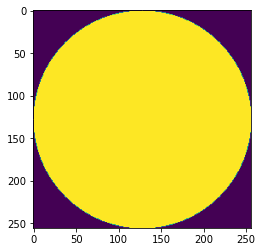

In [3]:
from prysm.geometry import circle
from matplotlib import pyplot as plt

A = circle(5, r)
plt.imshow(A)

Now we compute spherical aberration, $W040$ in Hopkins' notation, using $\rho = r / 5$, the radius of the pupil.

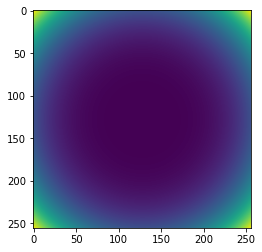

In [83]:
from prysm.polynomials import hopkins

rho = r / 5
phi = hopkins(0, 4, 0, rho, t, 1) # 1 = H, field height
plt.imshow(phi)

This looks wrong, but that's just because you can see outside the unit circle:

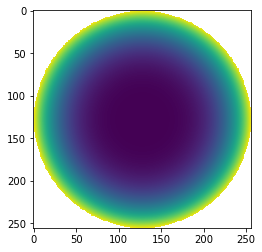

In [84]:
phi2 = phi.copy()
phi2[A!=1]=np.nan
plt.imshow(phi2)

Now we want to assemble $P$.  We first need to decide what the units of $\phi$ are, and for now we will assume they are nanometers, as good a choice of any.  1 nm of spherical is not interesting, so we will scale it to 500 nm zero-to-peak (the inherent "scaling" of Hopkins' polynomials).  We'll use the HeNe wavelength, grabbing it from prysm's set of common wavelengths.  It is just a float with units of microns.

In [85]:
from prysm.wavelengths import HeNe
from prysm.propagation import Wavefront

phi100 = phi * 500

dx = xi[0,1]-xi[0,0]

# None = no phase error
wf = Wavefront.from_amp_and_phase(A, None, HeNe, dx) # wf == P

Now we want to calculate the PSF associated with this wavefront.  This calculation happens in two steps, the first is to compute the complex field in the plane of the PSF, and the second to compute the so-called "intensity PSF" or "incoherent PSF".  We have

$$ E(x,y) = \mathfrak{F} \left[ P(\xi,\eta) \right] $$
with $\mathfrak{F}$ as the Fourier transform operator, and
$$ \text{PSF}_\text{inc}(x,y) = \left|E(x,y)\right|^2 $$

0.0390625 3.164


(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

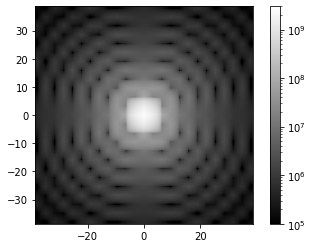

In [92]:
E = wf.focus(100)
psf = E.intensity
fno = 10
psf_radius = 1.22*HeNe*fno
psf.plot2d(xlim=psf_radius*5, log=True, cmap='gray',
           clim=(1e5,3e9), interpolation='bilinear')

The x and y ticks have units of microns.  We computed the airy radius and plotted +/- 5 airy radii, which we can see is true in the data.

We can compare this unaberrated PSF to one which contains spherical aberration:

0.0390625 3.164


(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

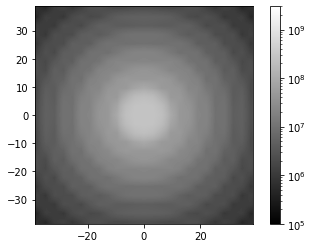

In [93]:
wf = Wavefront.from_amp_and_phase(A, phi100, HeNe, dx) # wf == P
E = wf.focus(100)
psf = E.intensity
psf.plot2d(xlim=psf_radius*5, log=True, cmap='gray',
           clim=(1e5,3e9), interpolation='bilinear')

We can see that spherical aberration broadens the PSF and reduces the visibility of the airy rings.

You may find these PSFs a bit "chunky."  The FFT propagation used can be zero-padded to improve spatial resolution:

0.0390625 0.791


(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

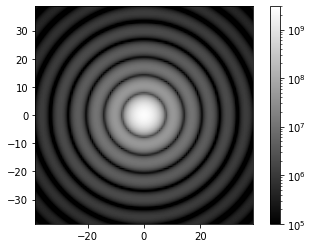

In [91]:
wf = Wavefront.from_amp_and_phase(A, None, HeNe, dx)
E = wf.focus(100, Q=8)
psf = E.intensity
psf.plot2d(xlim=psf_radius*5, log=True, cmap='gray',
           clim=(1e5,3e9), interpolation='bilinear')

That's it.

In summary, to produce a PSF from an aperture with or without wavefront error:

- use `prysm.coordinates` or your own code to produce a grid
- use `prysm.geometry` to shade the aperture
- use `prysm.polynomials` or your own code to create an optical path error map.  No need to zero the OPD outside the aperture.
- `use prysm.propagation.Wavefront` to propagate from the pupil (aperture) to the PSF plane.

The double slit experiment tutorial expands upon these ideas and includes angular spectrum or plane-to-plane propagation.